In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import math

def nCr(n,r):
    f = math.factorial
    return f(n) / f(r) / f(n-r)
sns.set()
# sns.set_theme()

In [2]:
# set the figure size
plt.rcParams['figure.figsize'] = [20, 20]

In [3]:
# set the number of the agent, attributes of agents
agentNum = 100

infectedList = np.zeros(agentNum)
# SEIR model
susceptState = np.ones(agentNum)
exposedState = np.zeros(agentNum)
infectState = np.zeros(agentNum)
recoverState = np.zeros(agentNum)

# E2I time, I2R time
timeAtBecomeE = np.zeros(agentNum)
timeAtBecomeI = np.zeros(agentNum)

In [4]:
# initial the SEIR, contact as output 
resTime = []
resSList = []
resEList = []
resIList = []
resRList = []
resContactList = []

In [5]:
# initial some parameter
s2eRatio = 0.016 # beta value for S to E

# time for I to remove
time4e2i = np.random.lognormal(mean=4.5, sigma=1.5, size=agentNum)
time4i2r = np.random.lognormal(mean=8, sigma=2, size=agentNum) # the average recover time

# time for E to I, this stage will 
# susceptList = np.random.lognormal(mean=4.5, sigma=1.5, size=agentNum)
# time for I to symptom
# symptomList = np.random.lognormal(mean=1.1, sigma=0.9, size=agentNum)

In [6]:
# initial contact matrix, infectious related
contactNetwork = np.random.normal(size=(agentNum, agentNum)) # use random at the first

# create the symmetry network
networkSym = contactNetwork.copy()
for i in range(networkSym.shape[0]):
    for j in range(i, networkSym.shape[1]):
        if networkSym[j][i] < 0:
            networkSym[j][i] = -networkSym[j][i]
        networkSym[i][j] = networkSym[j][i]

        if i == j :
            networkSym[i][j] = 0

In [7]:
# initial the simulation
myTime = 1
contactCount = 0
# at the begining we will assign the number of E patient
susceptState[0] = 0
exposedState[0] = 1
timeAtBecomeE[0] = myTime

# infectState, recoverState

susNumRatio = np.sum(susceptState)
expNumRatio = np.sum(exposedState)
infNumRatio = np.sum(infectState)
recNumRatio = np.sum(recoverState)
susRatio = susNumRatio/agentNum
expRatio = expNumRatio/agentNum
infRatio = infNumRatio/agentNum
recRatio = recNumRatio/agentNum

header = 'Time: '+str(myTime) + ', Contact: ' + str(contactCount) + '\n' + '\t'.join(['susNumRatio', 'expNumRatio', 'infNumRatio', 'recNumRatio'])
prtStr = '\t'.join([str(i) for i in [susNumRatio, expNumRatio, infNumRatio, recNumRatio]])
prtStr2 = '\t'.join([str(i) for i in [susRatio, expRatio, infRatio, recRatio]])

print('\n'.join([header, prtStr, prtStr2]))

resTime.append(myTime)
resSList.append(susRatio)
resEList.append(expRatio)
resIList.append(infRatio)
resRList.append(recRatio)
resContactList.append(contactCount)

Time: 1, Contact: 0
susNumRatio	expNumRatio	infNumRatio	recNumRatio
99.0	1.0	0.0	0.0
0.99	0.01	0.0	0.0


In [8]:
# use while true to get the simulation:
flag4print = 0
while(True):
    # step the simulation when time is to limited or rRatio to 1:
    if recRatio == 1:
        break
    if myTime == 100:# -1: # -1 for not setting the time
        break
    
    # begin contact, all people contact together                           
    susIndex = np.where(susceptState==1)[0]
    expIndex = np.where(exposedState==1)[0]
    infIndex = np.where(infectState==1)[0]
    recIndex = np.where(recoverState==1)[0]

    myTime = myTime + 1
    contactCount = 0

    # update E to I
    for i in expIndex: # only E will lead to E, I is reomved to be recover
        if myTime - timeAtBecomeE[i] > time4e2i[i]:
            # E to I
            exposedState[i] = 0
            infectState[i] = 1
            timeAtBecomeI[i] = myTime
            # record the expose time and E -> I

    # update I to R
    for i in infIndex: 
        if myTime - timeAtBecomeI[i] > time4i2r[i]:
            # I to R
            infectState[i] = 0
            recoverState[i] = 1

    # update S to E, only I cannot contact
    for i in range(agentNum):
        for j in range(i, agentNum):

            # Infectious cannot cantact
            if infectState[i] == 1 or infectState[i] == 1:
                continue

            # S, E, R can contact
            contactProbability = networkSym[i,j]
            if contactProbability > 1 : # make sure the Pr <= 1
                contactProbability = 1
            # print(contactProbability)

            # contact now
            if np.random.binomial(1,contactProbability):
                contactCount = contactCount + 1 # successful contact
                # print(str(i) + ' and ' + str(j) + ' contacts')

                # only Se, ES will change the state
                if exposedState[i] == 1 and susceptState[j] == 1:
                    if np.random.binomial(1, s2eRatio): # use beta value for S2E
                        susceptState[j] = 0
                        exposedState[j] = 1
                        timeAtBecomeE[j] = myTime
                        continue
                elif exposedState[j] == 1 and susceptState[i] == 1:
                    if np.random.binomial(1, s2eRatio): # use beta value for S2E
                        susceptState[i] = 0
                        exposedState[i] = 1
                        timeAtBecomeE[i] = myTime
                        continue

            else: # not contact
                contactCount = contactCount
                # print(str(i) + ' and ' + str(j) + ' not contacts')
    
    if flag4print == 1:
        print('Total number of contacts is ' + str(contactCount), flush=True) # the contact is important, that is the reason why we will record it

    # call the summary
    susNumRatio = np.sum(susceptState)
    expNumRatio = np.sum(exposedState)
    infNumRatio = np.sum(infectState)
    recNumRatio = np.sum(recoverState)
    susRatio = susNumRatio/agentNum
    expRatio = expNumRatio/agentNum
    infRatio = infNumRatio/agentNum
    recRatio = recNumRatio/agentNum

    header = 'Time: '+str(myTime) + ', Contact: ' + str(contactCount) + '\n' + '\t'.join(['susNumRatio', 'expNumRatio', 'infNumRatio', 'recNumRatio'])
    prtStr = '\t'.join([str(i) for i in [susNumRatio, expNumRatio, infNumRatio, recNumRatio]])
    prtStr2 = '\t'.join([str(i) for i in [susRatio, expRatio, infRatio, recRatio]])
    
    if flag4print == 1:
        print('\n'.join([header, prtStr, prtStr2]), flush=True)

    resTime.append(myTime)
    resSList.append(susRatio)
    resEList.append(expRatio)
    resIList.append(infRatio)
    resRList.append(recRatio)
    resContactList.append(contactCount)

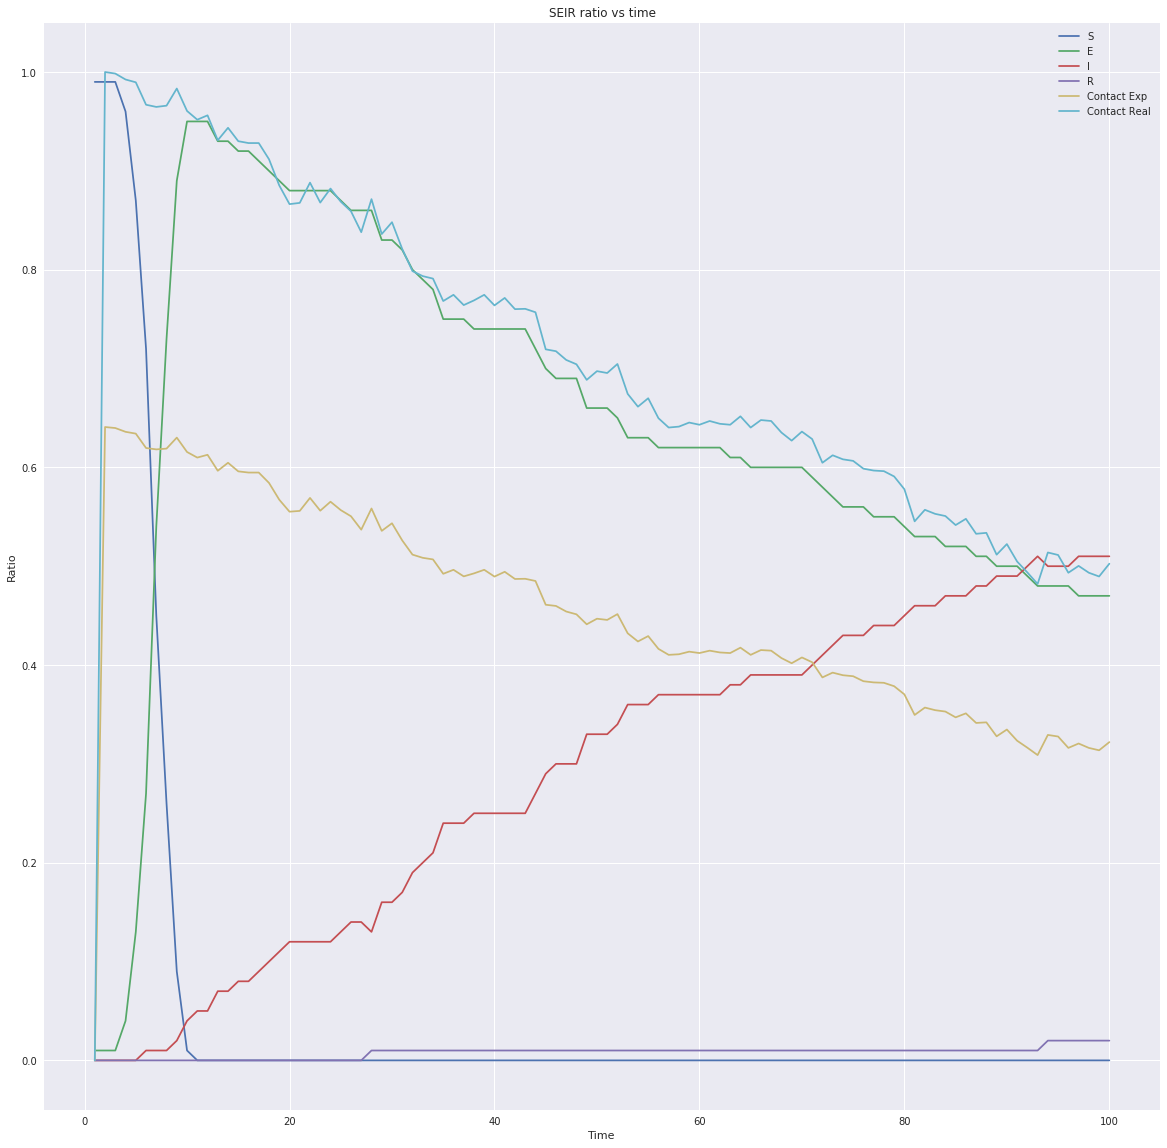

In [19]:
# demo the output
totalMaxContact = nCr(agentNum, 2)
expectedMaxContactRatio = [i/totalMaxContact for i in resContactList]
totalMaxContact =max(resContactList)
realMaxContactRatio = [i/totalMaxContact for i in resContactList]

fig, ax = plt.subplots(nrows=1, ncols=1,facecolor='white')
plt.title('SEIR ratio vs time')
plt.xlabel('Time')
plt.ylabel('Ratio')
ax.plot(resTime,resSList, label='S')
ax.plot(resTime,resEList, label='E')
ax.plot(resTime,resIList, label='I')
ax.plot(resTime,resRList, label='R')
ax.plot(resTime,expectedMaxContactRatio, label='Contact Exp')
ax.plot(resTime,realMaxContactRatio, label='Contact Real')
plt.legend()
plt.show()
ax.patch.set_facecolor('white')
# plt.title('SEIR ratio vs time')
# plt.xlabel('Time')
# plt.ylabel('Ratio')
# plt.plot(resTime,resSList, label='S')
# plt.plot(resTime,resEList, label='E')
# plt.plot(resTime,resIList, label='I')
# plt.plot(resTime,resRList, label='R')
# plt.plot(resTime,expectedMaxContactRatio, label='Contact Exp')
# plt.plot(resTime,realMaxContactRatio, label='Contact Real')
# plt.legend()
# plt.show()

In [9]:
# time for E to I, this stage will 
susceptList = np.random.lognormal(mean=4.5, sigma=1.5, size=agentNum)

# time for I to symptom
symptomList = np.random.lognormal(mean=1.1, sigma=0.9, size=agentNum)

In [10]:
contactNetwork = np.random.normal(size=(agentNum, agentNum))

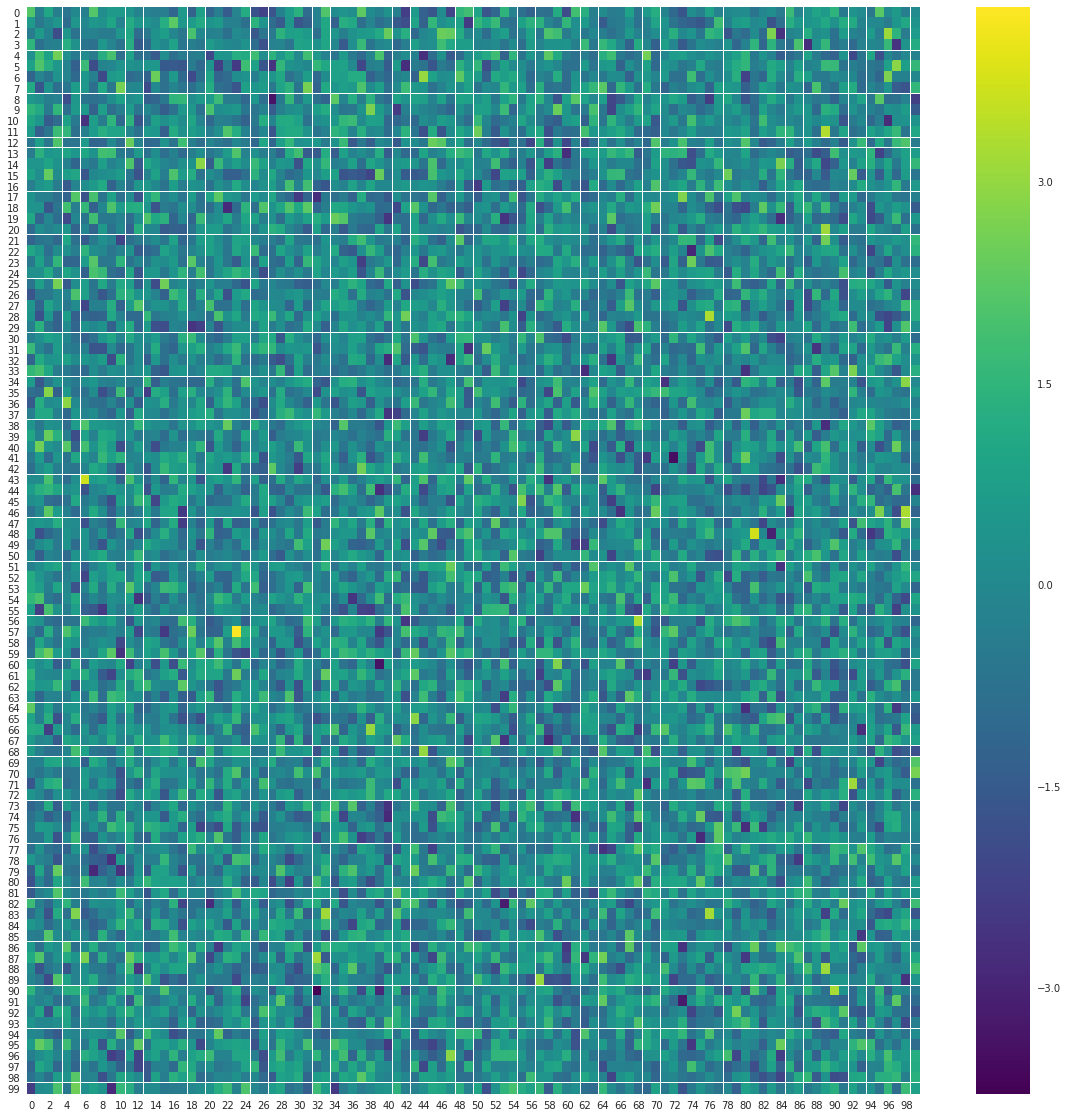

In [11]:
fig, axs = plt.subplots()
ax = sns.heatmap(contactNetwork,
                 linewidths=0.001,
                 cmap="viridis")

(array([85.,  7.,  4.,  1.,  0.,  0.,  0.,  2.,  0.,  1.]),
 array([2.02388427e+00, 3.47610990e+02, 6.93198096e+02, 1.03878520e+03,
        1.38437231e+03, 1.72995941e+03, 2.07554652e+03, 2.42113363e+03,
        2.76672073e+03, 3.11230784e+03, 3.45789494e+03]),
 <a list of 10 Patch objects>)

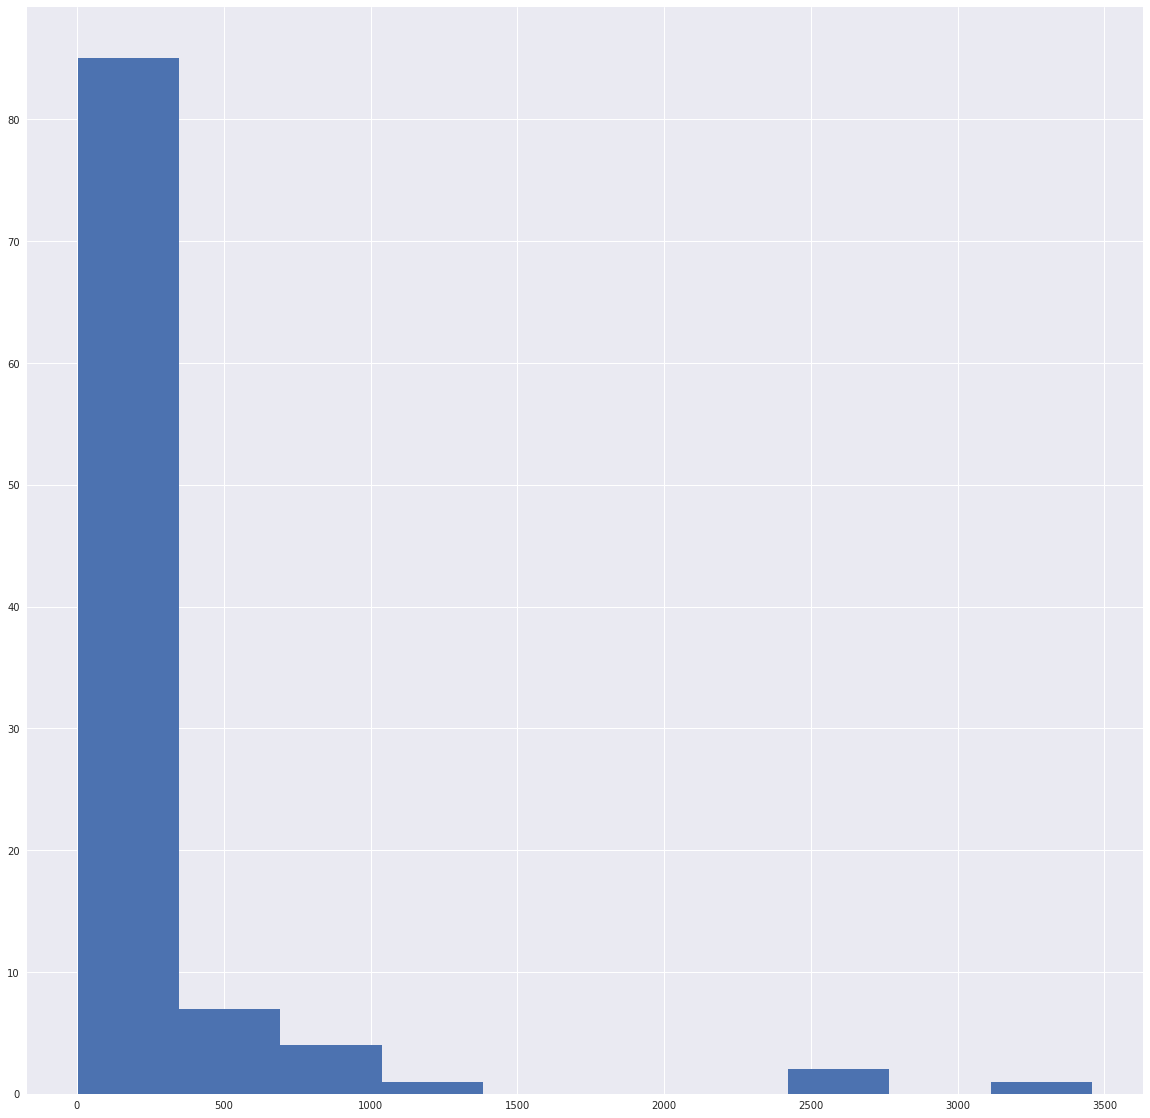

In [29]:
fig, axs = plt.subplots()
axs.hist(susceptList)

In [30]:
networkSym = contactNetwork.copy()


In [31]:
networkSym = contactNetwork.copy()
for i in range(networkSym.shape[0]):
    for j in range(i, networkSym.shape[1]):
        if networkSym[j][i] < 0:
            networkSym[j][i] = -networkSym[j][i]
        networkSym[i][j] = networkSym[j][i]

        if i == j :
            networkSym[i][j] = 0

In [32]:
np.min(networkSym)

0.0

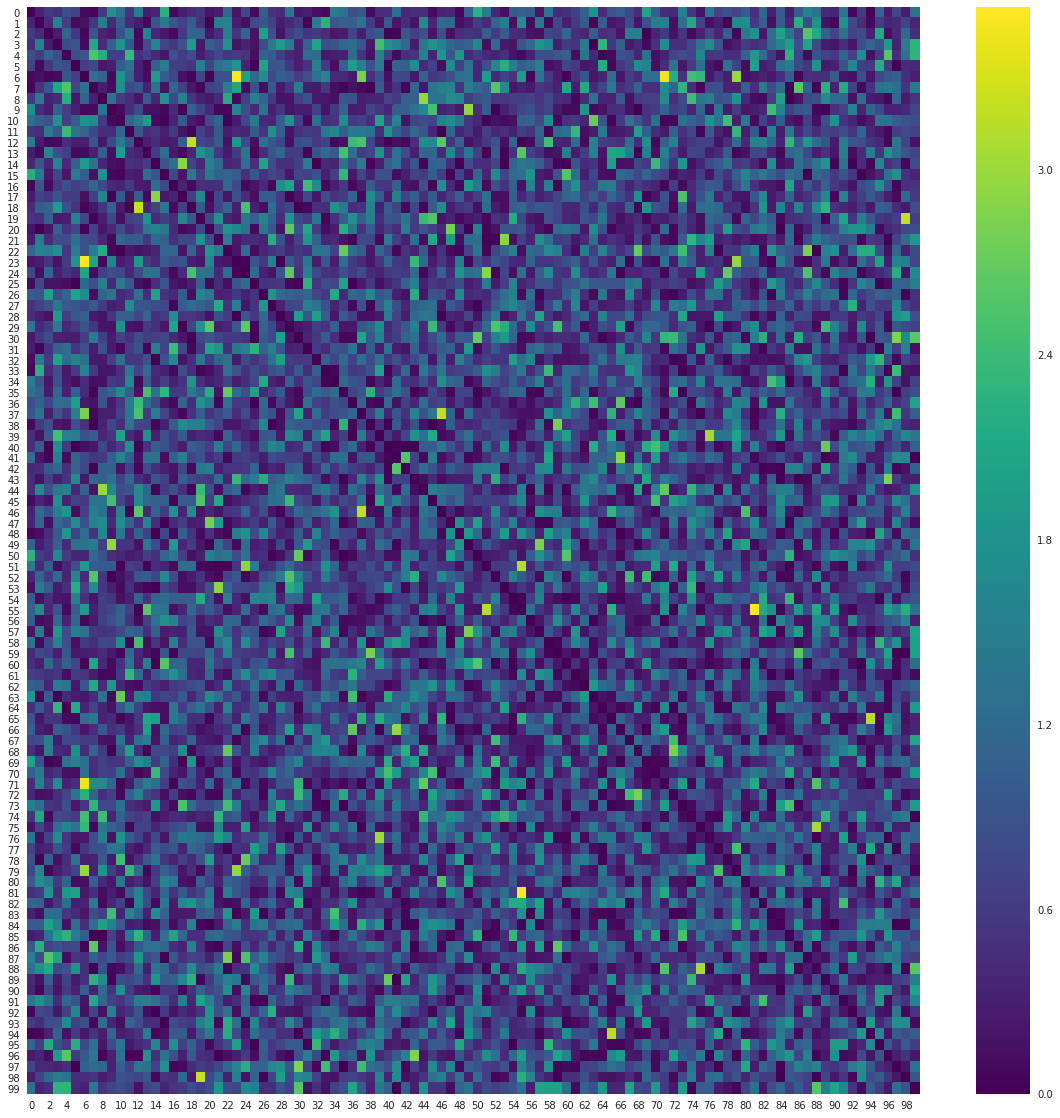

In [33]:
fig, axs = plt.subplots() # change the contact network to symmetry
ax = sns.heatmap(networkSym,
#                  linewidths=0.001,
                 cmap="viridis")

In [36]:
sns.distplot(networkSym)

/opt/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/opt/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


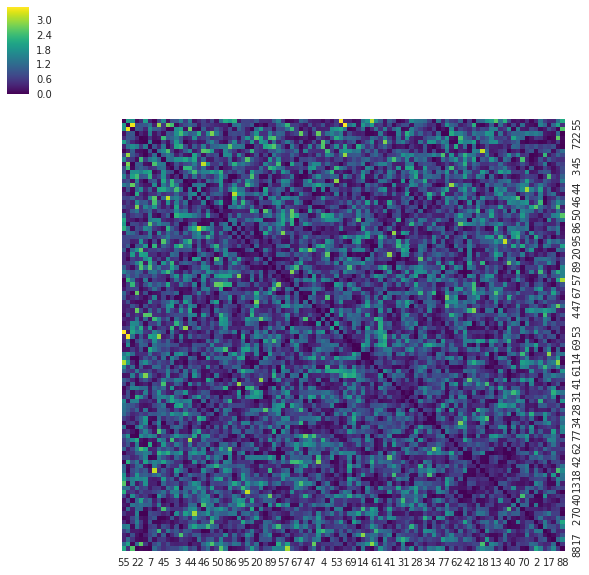

In [37]:
cg = sns.clustermap(networkSym,
#                row_cluster=False,
#                col_cluster=False,
#                  linewidths=0.001,
                 cmap="viridis")
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
# the cbar position can be moved to other places

Time: 1
susNumRatio	expNumRatio	infNumRatio	recNumRatio
99.0	1.0	0.0	0.0
0.99	0.01	0.0	0.0


In [39]:
expIndex

NameError: name 'expIndex' is not defined

In [40]:
# begin contact, all people contact together
contactCount = 0
s2eRatio = 0.016 # beta value for S to E

susIndex = np.where(susceptState==1)[0]
expIndex = np.where(exposedState==1)[0]
infIndex = np.where(infectState==1)[0]
recIndex = np.where(recoverState==1)[0]

myTime = myTime + 1
# update E to I
for i in expIndex:
    if myTime >= susceptList[i]:
        exposedState[i] = 0
        infectState[i] = 0
        
        # record the expose time and E -> I
        
        
        
        
for i in range(agentNum):
    for j in range(i, agentNum):
        
        
        
        
        contactProbability = networkSym[i,j]
        if contactProbability > 1 :
            contactProbability = 1
        
        # print(contactProbability)
        if np.random.binomial(1,contactProbability):
            contactCount = contactCount + 1
            # print(str(i) + ' and ' + str(j) + ' contacts')
            
            
            
        else:
            contactCount = contactCount
            # print(str(i) + ' and ' + str(j) + ' not contacts')

print('Total number of contacts is ' + str(contactCount))
# the contact is important, that is the reason why we will record it

susNumRatio = np.sum(susceptState)
expNumRatio = np.sum(exposedState)
infNumRatio = np.sum(infectState)
recNumRatio = np.sum(recoverState)
susRatio = susNumRatio/agentNum
expRatio = expNumRatio/agentNum
infRatio = infNumRatio/agentNum
recRatio = recNumRatio/agentNum

header = 'Time: '+str(myTime) + '\n' + '\t'.join(['susNumRatio', 'expNumRatio', 'infNumRatio', 'recNumRatio'])
prtStr = '\t'.join([str(i) for i in [susNumRatio, expNumRatio, infNumRatio, recNumRatio]])
prtStr2 = '\t'.join([str(i) for i in [susRatio, expRatio, infRatio, recRatio]])

print('\n'.join([header, prtStr, prtStr2]))


Total number of contacts is 3091
Time: 2
susNumRatio	expNumRatio	infNumRatio	recNumRatio
99.0	1.0	0.0	0.0
0.99	0.01	0.0	0.0


In [24]:
# begin contact, to speed up, only E and R will contact, others we don't care
contactCount = 0

currentEList = [] # will be updated in next version
for i in currentEList:
    for j in range(agentNum):
        
        
        contactProbability = networkSym[i,j]
        if contactProbability > 1 :
            contactProbability = 1
        
        # print(contactProbability)
        if np.random.binomial(1,contactProbability):
            contactCount = contactCount + 1
            # print(str(i) + ' and ' + str(j) + ' contacts')

        else:
            contactCount = contactCount
            # print(str(i) + ' and ' + str(j) + ' not contacts')

print('Total number of contacts is ' + str(contactCount))


0

In [12]:
myTime=[i for i in range(100)] 
susRatio=[i/100 for i in range(100)]
exposeRatio=[i/100 for i in range(100)] 
infecRatio=[i/100 for i in range(100)] 
recoverRatio=[i/100 for i in range(100)] 
interactionRatio=[i/100 for i in range(100)] 

In [13]:
myTime

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]